In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [3]:
start_year = 2014
end_year = 2024

# load and concat WRDS data for all years
wrds_data = []
for year in range(start_year, end_year + 1):
    df_year = pd.read_csv(f'Data/sp500_cleaned_{year}.csv')
    wrds_data.append(df_year)

wrds_file = pd.concat(wrds_data, ignore_index=True)

In [4]:
# drop columns with nan values
wrds_file = wrds_file.dropna(axis=1)

In [5]:
wrds_file["date"] = pd.to_datetime(wrds_file["date"])

In [6]:
print(wrds_file.isna().sum().sum()) # should be 0; else something's wrong
print(wrds_file.shape)
print("Unique tickers:", wrds_file['ticker'].nunique())

0
(52162, 66)
Unique tickers: 595


In [7]:
wrds_file.describe()

,date,bm,evm,pe_op_basic,pe_op_dil,pe_exi,ps,pcf,dpr,npm,...,SMA_3,SMA_6,vol_3m,vol_6m,EMA_3,EMA_6,RVOL_3,RVOL_6,vol_ROC,vol_mom
count,52162,52162.000000,52162.000000,52162.000000,52162.000000,52162.000000,52162.000000,52162.000000,52162.000000,52162.000000,...,52162.000000,52162.000000,52162.000000,52162.000000,52162.000000,52162.000000,52162.000000,52162.000000,52162.000000,52162.000000
mean,2019-09-23 08:25:59.756144384,0.417040,15.170631,21.207731,21.562459,21.865494,3.456568,16.138780,0.731525,0.113889,...,0.008915,0.009282,0.075104,0.080336,0.008856,0.009142,1.002678,1.007302,0.053868,0.004534
min,2014-01-31 00:00:00,0.000000,-5144.000000,-6873.600000,-6873.600000,-4090.000000,0.053000,-530.850000,-18.190000,-3.562000,...,-0.451646,-0.256781,0.000251,0.001521,-0.531570,-0.321131,0.216414,0.162490,-0.909627,-2.862151
25%,2016-12-31 00:00:00,0.162978,9.989250,12.815000,12.973250,12.735000,1.297250,8.082000,0.131000,0.057000,...,-0.017356,-0.009267,0.038488,0.050082,-0.017420,-0.009076,0.879212,0.847087,-0.171635,-0.039636
50%,2019-10-31 00:00:00,0.314000,12.998000,19.274000,19.468500,20.313000,2.410000,13.426500,0.335000,0.107000,...,0.010133,0.009854,0.062411,0.069518,0.010656,0.010309,0.982475,0.969114,-0.010574,0.008262
75%,2022-06-30 00:00:00,0.588000,17.425000,27.429000,27.769500,30.488750,4.228000,20.688500,0.571000,0.176000,...,0.036279,0.027936,0.096074,0.096979,0.036551,0.028028,1.100287,1.116240,0.191904,0.052777
max,2024-12-31 00:00:00,4.666000,5622.390000,717.400000,717.400000,756.167000,61.226000,421.549000,353.333000,2.284000,...,2.378350,1.196190,4.145405,2.929676,3.562152,2.049404,2.920619,5.646503,80.891584,3.891017
std,NaN,0.357492,89.177046,89.222806,92.097646,92.020920,3.630114,26.199092,4.933403,0.160726,...,0.054295,0.037496,0.066905,0.059719,0.054910,0.038029,0.190562,0.257920,0.527232,0.114581


In [465]:
# # log for all volume related columns
# volume_cols = ['volume', 'vol_SMA_3', 'vol_SMA_6']
# wrds_file[volume_cols] = wrds_file[volume_cols].applymap(lambda x: np.log1p(x))

Heatmap

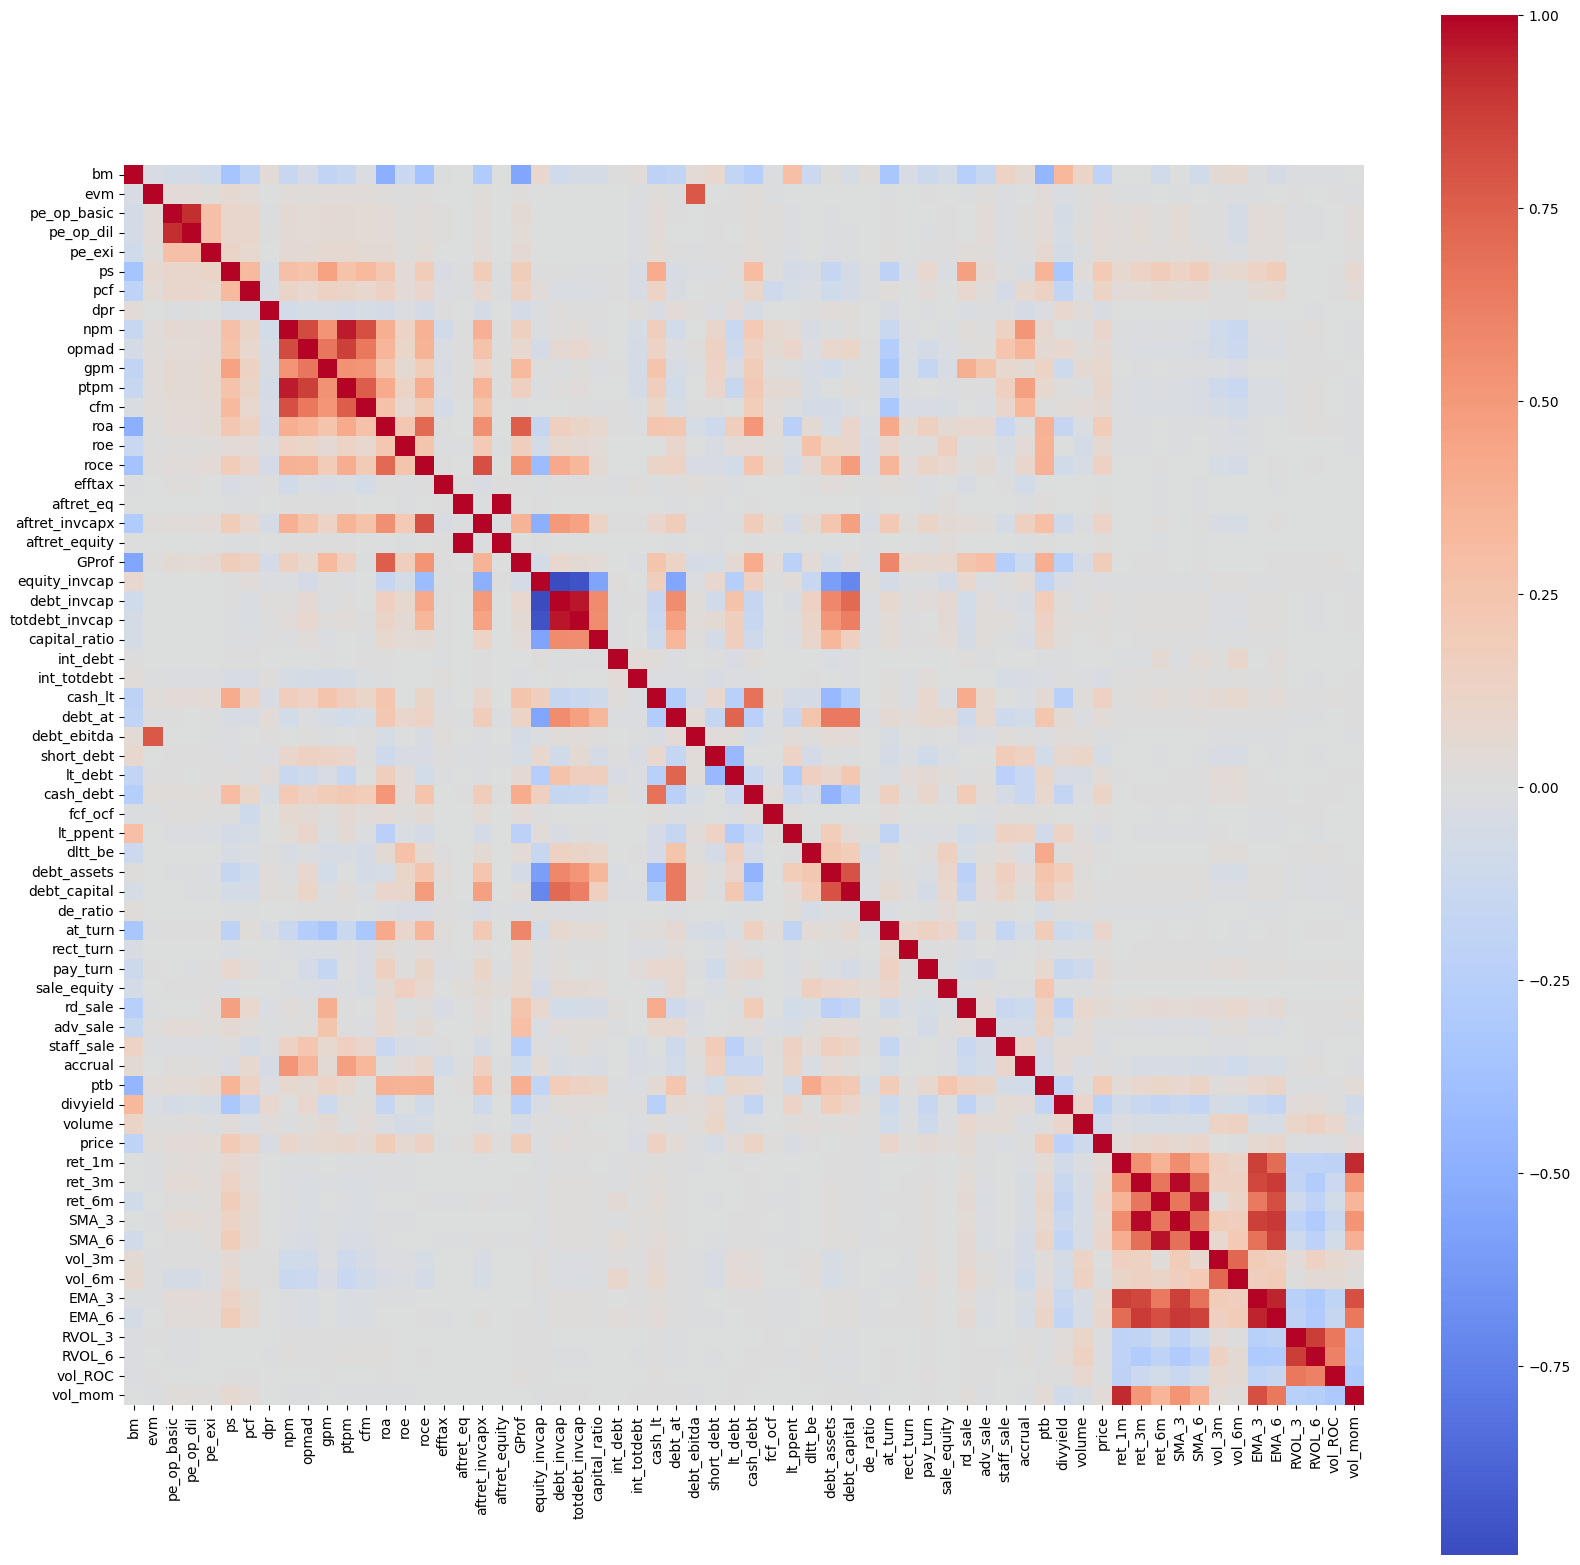

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))   
cols = wrds_file.select_dtypes(include='number').columns     # increase size
sns.heatmap(wrds_file[cols].corr(), 
            cmap='coolwarm', 
            square=True)
plt.show()


In [467]:
# find highly correlated features greater than 0.9
corr_matrix = wrds_file[cols].corr().abs()
threshold = 0.90
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [(col1, col2, upper.loc[col1, col2]) for col1 in upper.columns for col2 in upper.columns
    if (col1 != col2) and pd.notna(upper.loc[col1, col2]) and (upper.loc[col1, col2] > threshold)]

len(high_corr_pairs)
# high_corr_pairs

12

In [468]:
# aftret_eq',  'aftret_equity'
# correlation bw calculate
corr_matrix['aftret_eq']['aftret_equity']

0.9999999360703986

In [469]:
protected = {"ret_1m"}        # columns we must NOT drop
to_drop = set()

for col1, col2, corr_val in high_corr_pairs:
    # Skip pairs if already dropped
    if col1 in to_drop or col2 in to_drop:
        continue

    # Case 1: col1 is protected → drop col2
    if col1 in protected and col2 not in protected:
        to_drop.add(col2)
        continue

    # Case 2: col2 is protected → drop col1
    if col2 in protected and col1 not in protected:
        to_drop.add(col1)
        continue

    # Case 3: none protected → drop the second feature by default
    if col1 not in protected and col2 not in protected:
        to_drop.add(col2)

wrds_file = wrds_file.drop(columns=list(to_drop))
print("Dropped columns:", to_drop)


Dropped columns: {'totdebt_invcap', 'vol_mom', 'ptpm', 'SMA_6', 'SMA_3', 'debt_capital', 'debt_invcap', 'aftret_equity', 'EMA_6'}


In [11]:
spy = pd.read_csv('Data/SPY.csv') # Date, SPY
spy["Date"] = pd.to_datetime(spy["Date"])
spy["market_ret"] = spy["SPY"].pct_change()
spy.rename(columns={"Date": "date"}, inplace=True) # rename Date to date for merging
spy = spy[['date', 'market_ret']].dropna()
spy.head()

,date,market_ret
1,2010-02-28,0.029145
2,2010-03-31,0.055920
3,2010-04-30,0.015922
4,2010-05-31,-0.080875
5,2010-06-30,-0.056597


In [12]:
# join wrds_file with spy returns on date
wrds_file = wrds_file.merge(spy, on='date', how='left')


In [13]:
wrds_file.head()

,date,ticker,bm,evm,pe_op_basic,pe_op_dil,pe_exi,ps,pcf,dpr,...,SMA_6,vol_3m,vol_6m,EMA_3,EMA_6,RVOL_3,RVOL_6,vol_ROC,vol_mom,market_ret
0,2014-06-30,A,0.312,17.078,34.602,35.677,35.900,3.567,17.230,0.311,...,0.001148,0.043648,0.031987,0.012364,0.008273,0.767772,0.619175,-0.338974,0.006742,0.016448
1,2014-07-31,A,0.312,17.078,33.789,34.839,35.056,3.484,16.825,0.311,...,-0.005566,0.038754,0.032276,-0.005569,-0.000805,1.025161,0.845089,0.304423,-0.024094,-0.013746
2,2014-08-31,A,0.312,17.078,34.434,35.503,35.725,3.550,17.146,0.311,...,0.001110,0.022216,0.032591,0.006754,0.004875,1.072418,0.940138,-0.017132,0.020458,0.039308
3,2014-09-30,A,0.301,19.548,40.993,42.207,43.496,4.024,20.567,0.388,...,0.003542,0.021296,0.031427,0.001802,0.002582,0.947979,0.932442,-0.068001,-0.002985,-0.019089
4,2014-10-31,A,0.301,19.548,39.770,40.948,42.198,3.904,19.953,0.388,...,0.044222,0.032875,0.035091,0.036651,0.033042,1.096263,1.081097,0.142443,0.034994,0.024669


In [14]:
wrds_file.isna().sum().sum() # should be 0; else something's wrong

0

In [15]:
df = wrds_file.copy()
df.columns

Index(['date', 'ticker', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi',
       'ps', 'pcf', 'dpr', 'npm', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'debt_at',
       'debt_ebitda', 'short_debt', 'lt_debt', 'cash_debt', 'fcf_ocf',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'at_turn', 'rect_turn', 'pay_turn', 'sale_equity', 'rd_sale',
       'adv_sale', 'staff_sale', 'accrual', 'ptb', 'divyield', 'volume',
       'price', 'ret_1m', 'ret_3m', 'ret_6m', 'SMA_3', 'SMA_6', 'vol_3m',
       'vol_6m', 'EMA_3', 'EMA_6', 'RVOL_3', 'RVOL_6', 'vol_ROC', 'vol_mom',
       'market_ret'],
      dtype='object')

# Regression

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [17]:
# drop prices columns
df = df.drop(columns=['price']) # 'ret_3m', 'ret_6m'?

In [18]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date','ticker'])

factor_cols = [c for c in df.columns  if c not in ['date','ticker','market_ret','ret_1m']]

# Cross-sectional standardization by date [these are Betas]
df[factor_cols] = df.groupby('date')[factor_cols].transform(
    lambda x: (x - x.mean()) / x.std()
)


In [19]:
train = df[(df['date'] >= "2014-01-01") & (df['date'] <= "2022-01-01")]
val   = df[(df['date'] >= "2022-01-01") & (df['date'] <= "2022-12-31")]
test  = df[(df['date'] >= "2022-12-31") & (df['date'] <= "2024-12-31")]
# print("Train shape:", train.shape)
# print("Val shape:", val.shape)
# print("Test shape:", test.shape)


In [20]:
# for each stock, regress against market
alpha = {}
betas = {}
residuals = []

for ticker, grp in train.groupby('ticker'):
    if grp.shape[0] < 12:
        continue
    
    X = grp[['market_ret']].values
    y = grp['ret_1m'].values
    
    reg = LinearRegression().fit(X, y)
    beta_i = reg.coef_[0]
    
    betas[ticker] = beta_i
    alpha[ticker] = reg.intercept_
    # compute residuals
    eps = y - reg.predict(X)
    
    tmp = grp[['date','ticker']].copy()
    tmp['eps'] = eps
    residuals.append(tmp)

residuals = pd.concat(residuals)
train = train.merge(residuals, on=['date','ticker'], how='left')


In [21]:
from collections import defaultdict

gamma_time_series = defaultdict(list)
dates_used = []

for dt, grp in train.groupby('date'): # yaha group by date
    grp = grp.dropna(subset=['eps'] + factor_cols)
    if grp.shape[0] < len(factor_cols) + 10: # arbitary
        continue
    
    X = grp[factor_cols].values
    y = grp['eps'].values
    
    reg = LinearRegression().fit(X, y)
    
    for i, fc in enumerate(factor_cols):
        gamma_time_series[fc].append(reg.coef_[i])
    
    dates_used.append(dt)

T = len(dates_used)


In [22]:
len(gamma_time_series.keys())

62

In [23]:
gamma_bar = {}
t_stats = {}

for fc in factor_cols:
    arr = np.array(gamma_time_series[fc])
    gamma_bar[fc] = arr.mean()
    t_stats[fc] = gamma_bar[fc] / (arr.std(ddof=1) / np.sqrt(T))


In [24]:
selected = [fc for fc in factor_cols if abs(t_stats[fc]) > 1.96]
print("Selected factors:", len(selected))
print("Selected factors:", selected)


Selected factors: 18
Selected factors: ['bm', 'evm', 'ps', 'efftax', 'cash_lt', 'debt_ebitda', 'dltt_be', 'rect_turn', 'rd_sale', 'adv_sale', 'accrual', 'ptb', 'divyield', 'volume', 'SMA_3', 'EMA_3', 'EMA_6', 'vol_mom']


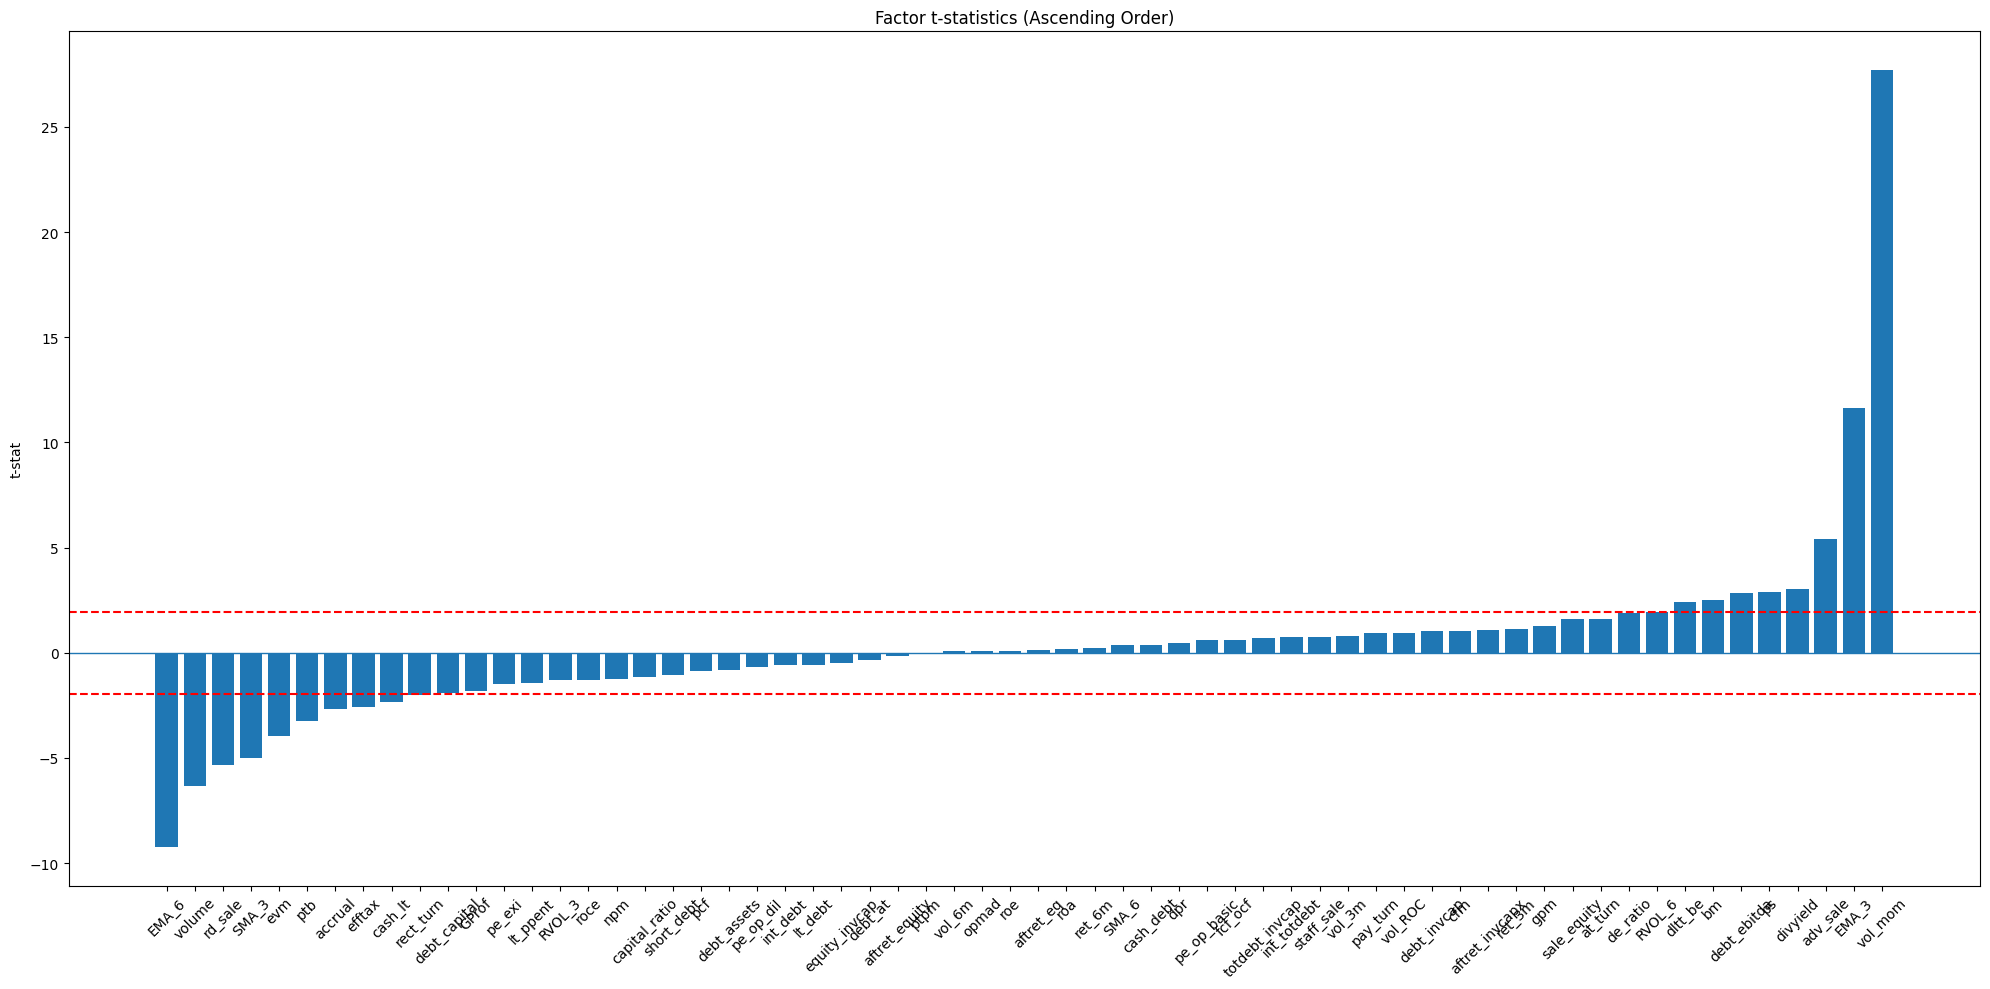

In [25]:
import matplotlib.pyplot as plt

# Sort by ascending t-stat
sorted_items = sorted(t_stats.items(), key=lambda x: x[1])

# Unpack sorted factors and values
factors = [item[0] for item in sorted_items]
values  = [item[1] for item in sorted_items]

plt.figure(figsize=(20,10))
plt.bar(factors, values)
plt.axhline(0, linewidth=1)
plt.axhline(1.96, color='red', linestyle='--', label='t=1.96')
plt.axhline(-1.96, color='red', linestyle='--')

plt.title("Factor t-statistics (Ascending Order)")
plt.ylabel("t-stat")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
gamma_star = defaultdict(list)

for dt, grp in train.groupby('date'):
    grp = grp.dropna(subset=['eps'] + selected)
    
    if grp.shape[0] < len(selected) + 3:
        continue
    
    X = grp[selected].values
    y = grp['eps'].values
    
    reg = LinearRegression().fit(X, y)
    
    for i, fc in enumerate(selected):
        gamma_star[fc].append(reg.coef_[i])


In [27]:
gamma_bar_star = {fc: np.mean(gamma_star[fc]) for fc in selected}
print("Final factor premia")

for fc, val in gamma_bar_star.items():
    print(f"{fc}: {val:.6f}")


Final factor premia
bm: 0.000739
evm: -0.002831
ps: 0.000948
efftax: -0.000431
cash_lt: -0.000527
debt_ebitda: 0.002062
dltt_be: 0.000518
rect_turn: -0.000190
rd_sale: -0.001949
adv_sale: 0.000948
accrual: -0.001044
ptb: -0.000696
divyield: 0.000610
volume: -0.001326
SMA_3: -0.019368
EMA_3: 0.075827
EMA_6: -0.030331
vol_mom: 0.038927


Total factors: 62
Data shape: (52162, 66)
Date range: 2014-01-31 00:00:00 to 2024-12-31 00:00:00

Train: (36890, 66)
Val: (5169, 66)
Test: (10537, 66)

Using risk-free rate: 0.020% monthly (0.24% annual)

STEP 1: Time Series Regression (Per Stock)
Number of stocks with residuals: 523
Training data with residuals: 36757 / 36890

STEP 2: Cross-Sectional Regression (Per Date)
Number of time periods used: 96
Number of factors: 62

STEP 3: Factor Selection

Selected factors: 18 out of 62

Top 10 factors by |t-stat|:
  vol_mom                       : t-stat =  27.846  ✓
  EMA_3                         : t-stat =  11.589  ✓
  EMA_6                         : t-stat =  -9.189  ✓
  volume                        : t-stat =  -6.347  ✓
  adv_sale                      : t-stat =   5.406  ✓
  rd_sale                       : t-stat =  -5.339  ✓
  SMA_3                         : t-stat =  -4.968  ✓
  evm                           : t-stat =  -3.983  ✓
  ptb                           : t-stat =  -3.238 

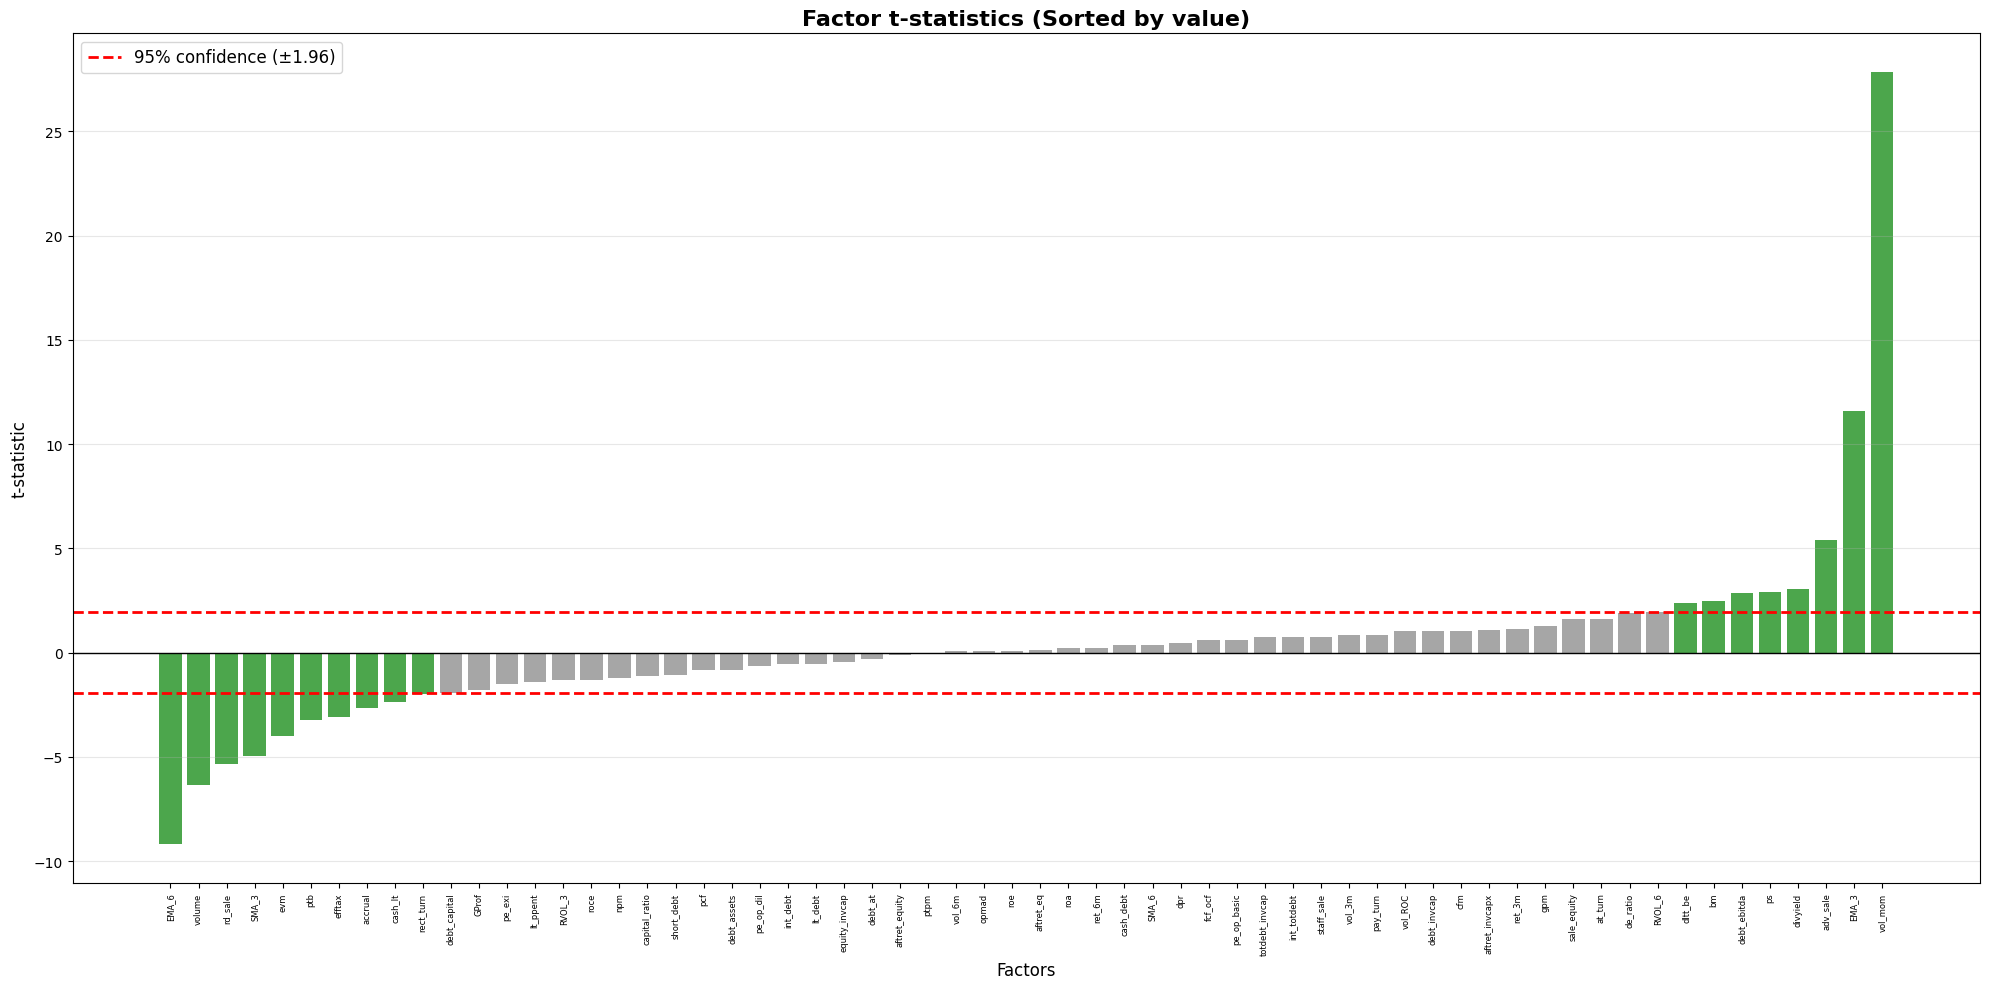


STEP 4: Compute Final Factor Premia

Final Factor Premia (γ̄*):
------------------------------------------------------------
  EMA_3                         : 0.075776
  vol_mom                       : 0.038812
  EMA_6                         : -0.030293
  SMA_3                         : -0.019354
  evm                           : -0.002839
  debt_ebitda                   : 0.002071
  rd_sale                       : -0.001948
  volume                        : -0.001327
  accrual                       : -0.001043
  ps                            : 0.000951
  adv_sale                      : 0.000948
  bm                            : 0.000735
  ptb                           : -0.000696
  divyield                      : 0.000611
  cash_lt                       : -0.000528
  dltt_be                       : 0.000519
  efftax                        : -0.000393
  rect_turn                     : -0.000191

STEP 5: Hyperparameter Tuning on Validation Set

Testing hyperparameter combinations...
T

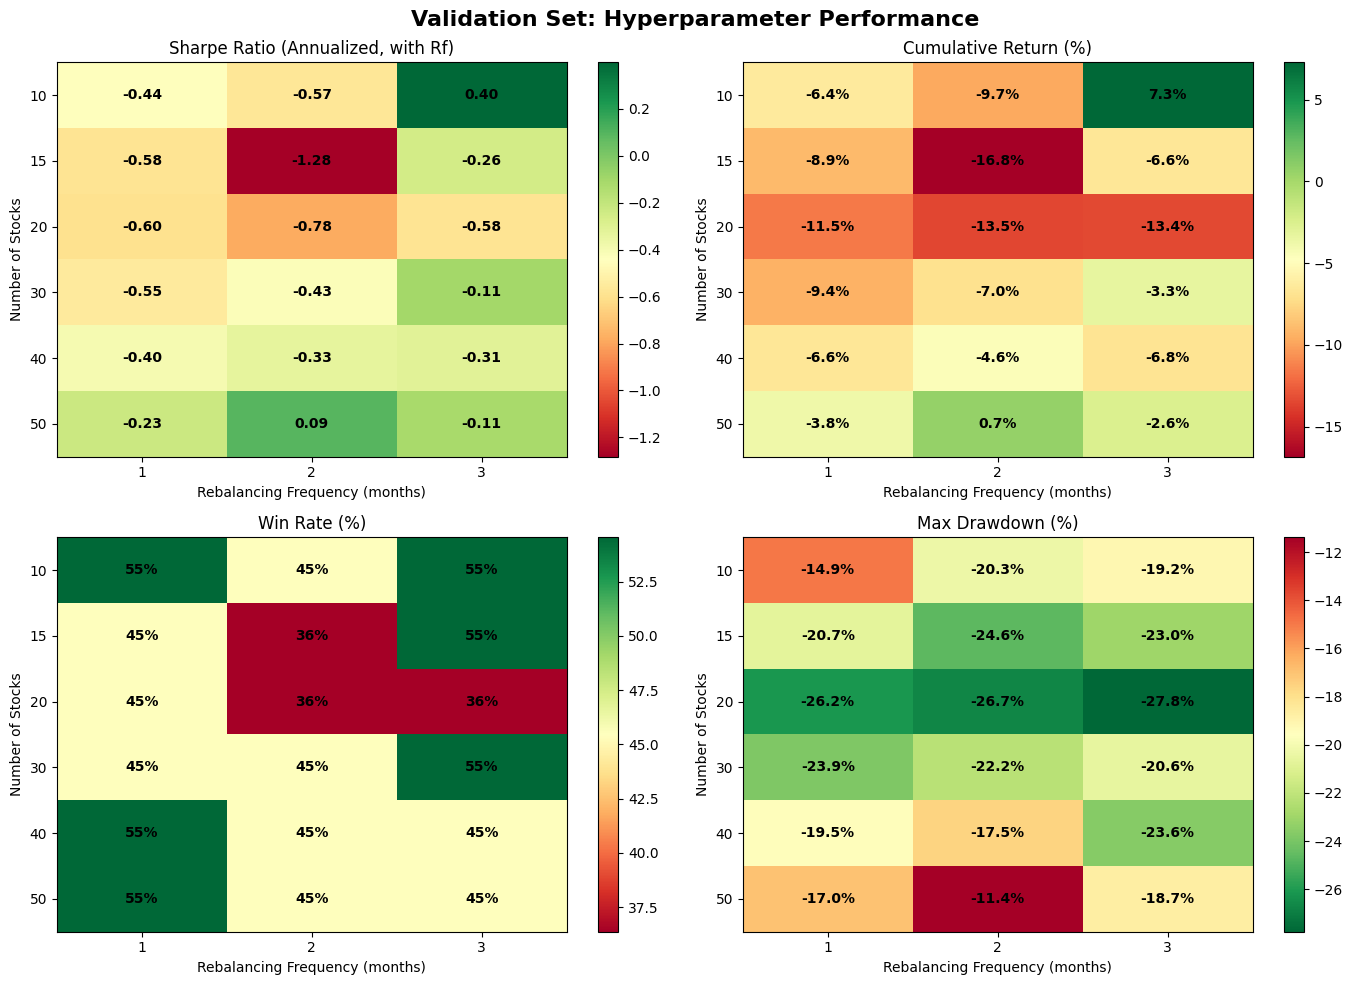


STEP 6: Final Evaluation on Test Set
Using best parameters: n_stocks=10, rebalance_freq=3

TEST SET PERFORMANCE

Starting Investment: $100.00
Investment Period: 24 months (2.00 years)
From: 2023-01-31 00:00:00
To:   2024-12-31 00:00:00

💰 FINAL PORTFOLIO VALUES:
  L/S Portfolio:  $94.44  (-5.56%)
  Long Only:      $128.14  (+28.14%)
  Short Only:     $125.60  (+25.60%)

📊 PERFORMANCE METRICS (with 0.020% monthly risk-free rate):
  Mean Monthly Return: -0.049%
  Mean Monthly Excess Return: -0.049%
  Volatility (monthly): 6.260%
  Sharpe Ratio (annualized, with Rf): -0.038
  Sortino Ratio (annualized): -0.062
  Annualized Return: -2.82%
  Information Ratio (vs Market): -0.809
  Win Rate: 45.8%
  Max Drawdown: -21.04%
  Number of Rebalances: 8


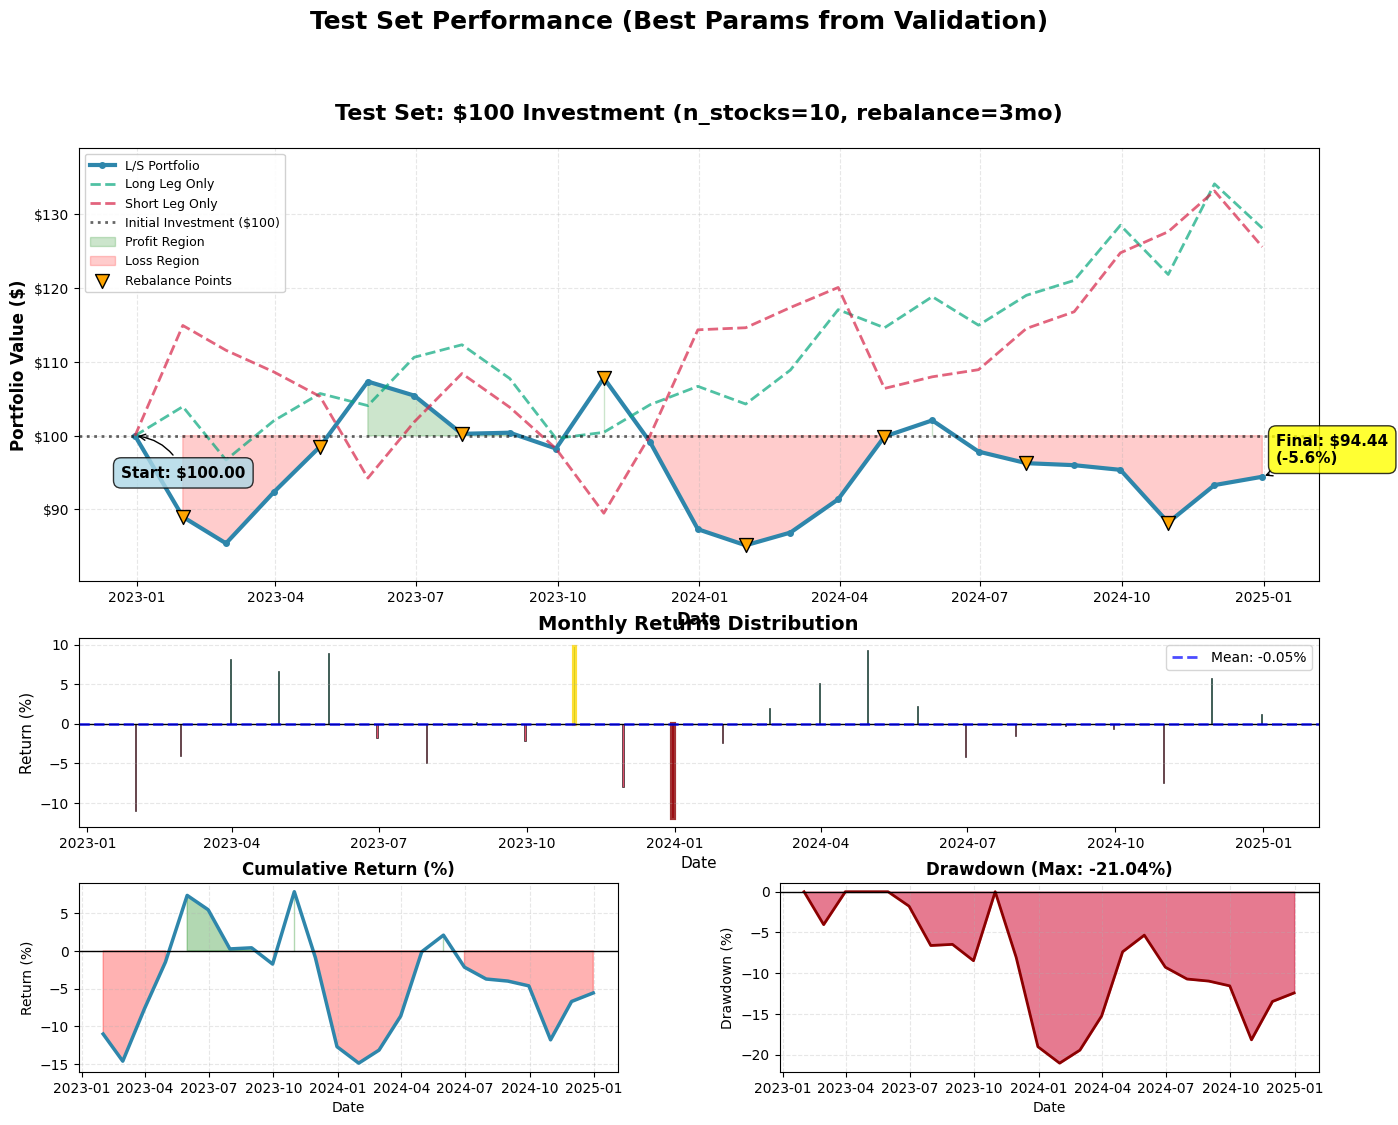


✅ Analysis Complete!

Best hyperparameters (from validation):
  - Number of stocks: 10 long, 10 short
  - Rebalancing: Every 3 month(s)

Validation performance:
  - Sharpe ratio: 0.397
  - Cumulative return: 7.29%

Test set performance:
  - Sharpe ratio: -0.038
  - Cumulative return: -5.56%
  - Final value: $94.44 from $100


In [28]:
# ========================================
# COMPLETE LONG/SHORT PORTFOLIO STRATEGY
# WITH VALIDATION-BASED HYPERPARAMETER TUNING
# ========================================

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict
import matplotlib.pyplot as plt
from itertools import product

# ========================================
# DATA PREPARATION
# ========================================

df = wrds_file.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date', 'ticker'])

# Drop price column
df = df.drop(columns=['price'])

# Identify factor columns
factor_cols = [c for c in df.columns if c not in ['date', 'ticker', 'market_ret', 'ret_1m']]

print(f"Total factors: {len(factor_cols)}")
print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Split data
train = df[(df['date'] >= "2014-01-01") & (df['date'] <= "2022-01-01")]
val   = df[(df['date'] >= "2022-01-01") & (df['date'] <= "2022-12-31")]
test  = df[(df['date'] >= "2022-12-31") & (df['date'] <= "2024-12-31")]

print(f"\nTrain: {train.shape}")
print(f"Val: {val.shape}")
print(f"Test: {test.shape}")

# ========================================
# RISK-FREE RATE SETUP
# ========================================
# Using approximate 3-month Treasury bill rate (monthly)
risk_free_monthly = 0.0002  # ~0.24% annual (typical 2024 T-bill yield)
print(f"\nUsing risk-free rate: {risk_free_monthly*100:.3f}% monthly ({((1+risk_free_monthly)**12-1)*100:.2f}% annual)")

# ========================================
# STEP 1: TIME SERIES REGRESSION (PER STOCK)
# Regress each stock's returns on market returns
# r_i,t = alpha_i + beta_i * r_m,t + eps_i,t
# ========================================

print("\n" + "="*60)
print("STEP 1: Time Series Regression (Per Stock)")
print("="*60)

alpha_dict = {}
beta_dict = {}
residuals_list = []

for ticker, grp in train.groupby('ticker'):
    # Need sufficient observations
    if grp.shape[0] < 12:
        continue
    
    # Drop any NaN values
    grp_clean = grp.dropna(subset=['ret_1m', 'market_ret'])
    if grp_clean.shape[0] < 12:
        continue
    
    X = grp_clean[['market_ret']].values
    y = grp_clean['ret_1m'].values
    
    # Fit: r_i,t = alpha_i + beta_i * r_m,t + eps_i,t
    reg = LinearRegression().fit(X, y)
    
    alpha_dict[ticker] = reg.intercept_
    beta_dict[ticker] = reg.coef_[0]
    
    # Compute residuals
    eps = y - reg.predict(X)
    
    # Store residuals with date/ticker
    tmp = grp_clean[['date', 'ticker']].copy()
    tmp['eps'] = eps
    residuals_list.append(tmp)

# Merge residuals back to training data
residuals_df = pd.concat(residuals_list, ignore_index=True)
train = train.merge(residuals_df, on=['date', 'ticker'], how='left')

print(f"Number of stocks with residuals: {len(alpha_dict)}")
print(f"Training data with residuals: {train['eps'].notna().sum()} / {len(train)}")

# ========================================
# STEP 2: CROSS-SECTIONAL REGRESSION (PER TIME PERIOD)
# For each date, regress residuals on normalized factors
# eps_i,t = alpha_t + sum(gamma_k,t * factor_k,i,t) + u_i,t
# ========================================

print("\n" + "="*60)
print("STEP 2: Cross-Sectional Regression (Per Date)")
print("="*60)

gamma_time_series = defaultdict(list)
dates_used = []

for dt, grp in train.groupby('date'):
    # Drop rows with missing residuals or factors
    grp_clean = grp.dropna(subset=['eps'] + factor_cols)
    
    # Need enough observations
    if grp_clean.shape[0] < len(factor_cols) + 10:
        continue
    
    # CRITICAL: Normalize factors cross-sectionally at time t
    X_raw = grp_clean[factor_cols].copy()
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
    # Check for any remaining NaN/inf
    if X_normalized.isnull().any().any() or np.isinf(X_normalized.values).any():
        continue
    
    y = grp_clean['eps'].values
    
    # Regress: eps_i,t = alpha_t + sum(gamma_k,t * factor_k,i,t) + u_i,t
    reg = LinearRegression().fit(X_normalized.values, y)
    
    # Store gamma coefficients for each factor
    for i, fc in enumerate(factor_cols):
        gamma_time_series[fc].append(reg.coef_[i])
    
    dates_used.append(dt)

T = len(dates_used)
print(f"Number of time periods used: {T}")
print(f"Number of factors: {len(factor_cols)}")

# ========================================
# STEP 3: FACTOR SELECTION
# Compute t-statistics and select significant factors
# t-stat = gamma_bar / (gamma_std / sqrt(T))
# ========================================

print("\n" + "="*60)
print("STEP 3: Factor Selection")
print("="*60)

gamma_bar = {}
gamma_std = {}
t_stats = {}

for fc in factor_cols:
    arr = np.array(gamma_time_series[fc])
    
    gamma_bar[fc] = arr.mean()
    gamma_std[fc] = arr.std(ddof=1)
    
    # t-statistic: mean / (std / sqrt(T))
    t_stats[fc] = gamma_bar[fc] / (gamma_std[fc] / np.sqrt(T))

# Select factors with |t-stat| > 1.96 (95% confidence)
selected = [fc for fc in factor_cols if abs(t_stats[fc]) > 1.96]

print(f"\nSelected factors: {len(selected)} out of {len(factor_cols)}")
print("\nTop 10 factors by |t-stat|:")
sorted_factors = sorted(t_stats.items(), key=lambda x: abs(x[1]), reverse=True)
for fc, tstat in sorted_factors[:10]:
    selected_mark = "✓" if fc in selected else ""
    print(f"  {fc:30s}: t-stat = {tstat:7.3f}  {selected_mark}")

# Visualize t-statistics
sorted_items = sorted(t_stats.items(), key=lambda x: x[1])
factors_sorted = [item[0] for item in sorted_items]
values_sorted = [item[1] for item in sorted_items]

plt.figure(figsize=(20, 10))
colors = ['green' if abs(v) > 1.96 else 'gray' for v in values_sorted]
plt.bar(factors_sorted, values_sorted, color=colors, alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.axhline(1.96, color='red', linestyle='--', linewidth=2, label='95% confidence (±1.96)')
plt.axhline(-1.96, color='red', linestyle='--', linewidth=2)
plt.title("Factor t-statistics (Sorted by value)", fontsize=16, fontweight='bold')
plt.ylabel("t-statistic", fontsize=12)
plt.xlabel("Factors", fontsize=12)
plt.xticks(rotation=90, fontsize=6)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# ========================================
# STEP 4: COMPUTE FINAL FACTOR PREMIA
# Re-run with only selected factors, get gamma_bar_star
# ========================================

print("\n" + "="*60)
print("STEP 4: Compute Final Factor Premia")
print("="*60)

gamma_star = defaultdict(list)

for dt, grp in train.groupby('date'):
    grp_clean = grp.dropna(subset=['eps'] + selected)
    
    if grp_clean.shape[0] < len(selected) + 3:
        continue
    
    # Normalize selected factors cross-sectionally
    X_raw = grp_clean[selected].copy()
    X_normalized = (X_raw - X_raw.mean()) / X_raw.std()
    
    if X_normalized.isnull().any().any() or np.isinf(X_normalized.values).any():
        continue
    
    y = grp_clean['eps'].values
    
    reg = LinearRegression().fit(X_normalized.values, y)
    
    for i, fc in enumerate(selected):
        gamma_star[fc].append(reg.coef_[i])

# Average across time: gamma_bar_star
gamma_bar_star = {fc: np.mean(gamma_star[fc]) for fc in selected}

print("\nFinal Factor Premia (γ̄*):")
print("-" * 60)
for fc in sorted(gamma_bar_star.keys(), key=lambda x: abs(gamma_bar_star[x]), reverse=True):
    print(f"  {fc:30s}: {gamma_bar_star[fc]:8.6f}")

# ========================================
# PERFORMANCE METRICS FUNCTIONS
# ========================================

def calculate_sharpe_with_rf(returns_series, risk_free_rate, freq=12):
    """
    Calculate annualized Sharpe ratio using risk-free rate
    
    Parameters:
    -----------
    returns_series : pd.Series
        Portfolio returns
    risk_free_rate : float
        Risk-free rate per period
    freq : int
        Number of periods per year (12 for monthly)
    
    Returns:
    --------
    float : Annualized Sharpe ratio
    """
    if len(returns_series) < 2:
        return 0.0
    
    # Calculate excess returns
    excess_returns = returns_series - risk_free_rate
    
    # Annualized metrics
    annualized_excess_return = excess_returns.mean() * freq
    annualized_volatility = returns_series.std(ddof=1) * np.sqrt(freq)
    
    return annualized_excess_return / annualized_volatility if annualized_volatility > 0 else 0.0

def calculate_sortino_ratio(returns_series, risk_free_rate, freq=12):
    """
    Calculate Sortino ratio (downside deviation only)
    """
    if len(returns_series) < 2:
        return 0.0
    
    excess_returns = returns_series - risk_free_rate
    downside_returns = excess_returns[excess_returns < 0]
    
    if len(downside_returns) < 2:
        return 0.0
    
    annualized_excess_return = excess_returns.mean() * freq
    downside_std = downside_returns.std(ddof=1) * np.sqrt(freq)
    
    return annualized_excess_return / downside_std if downside_std > 0 else 0.0

def calculate_max_drawdown(portfolio_values):
    """
    Calculate maximum drawdown from portfolio values
    """
    if len(portfolio_values) < 2:
        return 0.0
    
    cumulative = portfolio_values
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

# ========================================
# ENHANCED PORTFOLIO CONSTRUCTION FUNCTION
# ========================================

def build_portfolio_enhanced(data, alpha_dict, beta_dict, gamma_bar_star, selected,
                             n_long, n_short, rebalance_freq, winsorize_pct=0.05,
                             min_price=5.0, risk_free_rate=0.0002):
    """
    Build and evaluate portfolio with enhanced features
    
    Parameters:
    -----------
    data : DataFrame
        Data to evaluate on (val or test)
    alpha_dict : dict
        Alpha values from training
    beta_dict : dict
        Beta values from training
    gamma_bar_star : dict
        Factor premia from training
    selected : list
        Selected factors
    n_long : int
        Number of stocks to long
    n_short : int
        Number of stocks to short
    rebalance_freq : int
        Rebalancing frequency in months
    winsorize_pct : float
        Percentage to winsorize from top and bottom
    min_price : float
        Minimum stock price to include
    risk_free_rate : float
        Monthly risk-free rate
    
    Returns:
    --------
    portfolio_df : DataFrame
        Portfolio returns for each period
    """
    
    oos_data = data.copy()
    oos_data = oos_data.sort_values(['ticker', 'date'])
    
    all_dates = sorted(oos_data['date'].unique())
    portfolio_returns = []
    
    # Track current portfolio
    current_long_tickers = None
    current_short_tickers = None
    months_held = 0
    
    for i in range(len(all_dates) - 1):
        current_date = all_dates[i]
        next_date = all_dates[i + 1]
        
        # Get data at time t (for portfolio formation)
        grp_t = oos_data[oos_data['date'] == current_date].copy()
        
        # Get data at time t+1 (for realized returns)
        grp_t1 = oos_data[oos_data['date'] == next_date].copy()
        
        # Apply minimum price filter if price column exists
        if 'price' in grp_t.columns:
            grp_t = grp_t[grp_t['price'] >= min_price]
        
        # Skip if not enough stocks
        if len(grp_t) < (n_long + n_short):
            continue
        
        # =====================================
        # REBALANCING LOGIC
        # =====================================
        
        # Check if we need to rebalance
        should_rebalance = (current_long_tickers is None) or (months_held >= rebalance_freq)
        
        if should_rebalance:
            # Normalize factors cross-sectionally at time t
            for fc in factor_cols:
                if grp_t[fc].notna().sum() > 1:
                    mean_val = grp_t[fc].mean()
                    std_val = grp_t[fc].std()
                    if std_val > 0:
                        grp_t[fc] = (grp_t[fc] - mean_val) / std_val
                    else:
                        grp_t[fc] = 0
            
            # Predict idiosyncratic component using selected factors
            grp_t['eps_pred'] = 0.0
            for fc in selected:
                grp_t['eps_pred'] += grp_t[fc].fillna(0) * gamma_bar_star[fc]
            
            # Map alpha and beta from training
            grp_t['alpha_i'] = grp_t['ticker'].map(alpha_dict)
            grp_t['beta_i'] = grp_t['ticker'].map(beta_dict)
            
            # Expected market return - use historical average
            historical_market = oos_data[oos_data['date'] < current_date]['market_ret']
            if len(historical_market) >= 12:
                grp_t['E_r_m'] = historical_market.tail(12).mean()
            else:
                # If insufficient history, use risk-free rate as baseline
                grp_t['E_r_m'] = risk_free_rate
            
            # Total predicted return
            grp_t['r_pred'] = (
                grp_t['alpha_i'].fillna(0) + 
                grp_t['beta_i'].fillna(0) * grp_t['E_r_m'] + 
                grp_t['eps_pred']
            )
            
            # Drop stocks with missing predictions
            grp_t = grp_t.dropna(subset=['r_pred', 'alpha_i', 'beta_i'])
            
            # Apply winsorization to remove extreme predictions
            if winsorize_pct > 0 and len(grp_t) > 10:
                lower_bound = grp_t['r_pred'].quantile(winsorize_pct)
                upper_bound = grp_t['r_pred'].quantile(1 - winsorize_pct)
                grp_t = grp_t[(grp_t['r_pred'] >= lower_bound) & (grp_t['r_pred'] <= upper_bound)]
            
            if len(grp_t) < (n_long + n_short):
                continue
            
            # Rank by predicted return
            grp_t = grp_t.sort_values('r_pred', ascending=False)
            
            # Select with buffer to account for delistings
            buffer_factor = 1.5  # Take 50% more than needed
            candidate_long = grp_t.head(int(n_long * buffer_factor))['ticker'].tolist()
            candidate_short = grp_t.tail(int(n_short * buffer_factor))['ticker'].tolist()
            
            # Check which candidates have returns in next period
            available_next = grp_t1['ticker'].tolist()
            current_long_tickers = [t for t in candidate_long if t in available_next][:n_long]
            current_short_tickers = [t for t in candidate_short if t in available_next][:n_short]
            
            # Reset counter
            months_held = 0
        
        # =====================================
        # MEASURE RETURNS FOR CURRENT HOLDINGS
        # =====================================
        
        # Get returns at t+1 for current holdings
        long_rets = grp_t1[grp_t1['ticker'].isin(current_long_tickers)]['ret_1m']
        short_rets = grp_t1[grp_t1['ticker'].isin(current_short_tickers)]['ret_1m']
        
        # Skip if we don't have enough stocks with realized returns
        if len(long_rets) < max(1, n_long // 2) or len(short_rets) < max(1, n_short // 2):
            # If too many stocks dropped out, force rebalance next period
            current_long_tickers = None
            current_short_tickers = None
            months_held = 0
            continue
        
        # Calculate equal-weighted portfolio returns
        long_ret = long_rets.mean()
        short_ret = short_rets.mean()
        ls_ret = long_ret - short_ret
        
        # Calculate excess returns over risk-free rate
        long_excess = long_ret - risk_free_rate
        short_excess = short_ret - risk_free_rate
        ls_excess = long_excess - short_excess
        
        portfolio_returns.append({
            'formation_date': current_date,
            'return_date': next_date,
            'long_return': long_ret,
            'short_return': short_ret,
            'ls_return': ls_ret,
            'long_excess': long_excess,
            'short_excess': short_excess,
            'ls_excess': ls_excess,
            'market_return': grp_t1['market_ret'].mean() if 'market_ret' in grp_t1.columns else 0,
            'n_long': len(long_rets),
            'n_short': len(short_rets),
            'rebalanced': should_rebalance
        })
        
        # Increment months held
        months_held += 1
    
    portfolio_df = pd.DataFrame(portfolio_returns)
    return portfolio_df

# ========================================
# STEP 5: HYPERPARAMETER TUNING ON VALIDATION SET
# Test different combinations of:
# - Number of stocks (n_stocks: 10, 15, 20 per leg)
# - Rebalancing frequency (1, 2, 3 months)
# ========================================

print("\n" + "="*60)
print("STEP 5: Hyperparameter Tuning on Validation Set")
print("="*60)

# Define hyperparameter grid
n_stocks_options = [10, 15, 20, 30, 40, 50]
rebalance_freq_options = [1, 2, 3]

# Store results
tuning_results = []

print("\nTesting hyperparameter combinations...")
print(f"Total combinations: {len(n_stocks_options) * len(rebalance_freq_options)}")

for n_stocks, rebalance_freq in product(n_stocks_options, rebalance_freq_options):
    print(f"\nTesting: n_stocks={n_stocks}, rebalance_freq={rebalance_freq} months")
    
    # Build portfolio on validation set
    val_portfolio = build_portfolio_enhanced(
        data=val,
        alpha_dict=alpha_dict,
        beta_dict=beta_dict,
        gamma_bar_star=gamma_bar_star,
        selected=selected,
        n_long=n_stocks,
        n_short=n_stocks,
        rebalance_freq=rebalance_freq,
        winsorize_pct=0.0,
        min_price=5.0,
        risk_free_rate=risk_free_monthly
    )
    
    if len(val_portfolio) == 0:
        print(f"  ⚠️  No valid periods - skipping")
        continue
    
    # Calculate performance metrics
    mean_return = val_portfolio['ls_return'].mean()
    mean_excess = val_portfolio['ls_excess'].mean()
    std_return = val_portfolio['ls_return'].std()
    
    # Calculate Sharpe ratio with risk-free rate
    sharpe_annual = calculate_sharpe_with_rf(
        val_portfolio['ls_return'],
        risk_free_rate=risk_free_monthly,
        freq=12
    )
    
    # Calculate Sortino ratio
    sortino_annual = calculate_sortino_ratio(
        val_portfolio['ls_return'],
        risk_free_rate=risk_free_monthly,
        freq=12
    )
    
    # Cumulative return
    cum_return = (1 + val_portfolio['ls_return']).prod() - 1
    
    # Win rate
    win_rate = (val_portfolio['ls_return'] > 0).sum() / len(val_portfolio)
    
    # Max drawdown
    cumulative_values = 100 * (1 + val_portfolio['ls_return']).cumprod()
    max_drawdown = calculate_max_drawdown(cumulative_values)
    
    # Number of rebalances
    n_rebalances = val_portfolio['rebalanced'].sum()
    
    tuning_results.append({
        'n_stocks': n_stocks,
        'rebalance_freq': rebalance_freq,
        'n_periods': len(val_portfolio),
        'mean_return': mean_return,
        'mean_excess': mean_excess,
        'std_return': std_return,
        'sharpe_annual': sharpe_annual,
        'sortino_annual': sortino_annual,
        'cum_return': cum_return,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'n_rebalances': n_rebalances
    })
    
    print(f"  Periods: {len(val_portfolio)}")
    print(f"  Mean return: {mean_return*100:.3f}%")
    print(f"  Mean excess return: {mean_excess*100:.3f}%")
    print(f"  Sharpe (annual): {sharpe_annual:.3f}")
    print(f"  Sortino (annual): {sortino_annual:.3f}")
    print(f"  Cum return: {cum_return*100:.2f}%")
    print(f"  Win rate: {win_rate*100:.1f}%")
    print(f"  Max drawdown: {max_drawdown*100:.2f}%")
    print(f"  Rebalances: {n_rebalances}")

# Convert to DataFrame
tuning_df = pd.DataFrame(tuning_results)

print("\n" + "="*60)
print("VALIDATION RESULTS SUMMARY")
print("="*60)
print(tuning_df.to_string(index=False))

# ========================================
# SELECT BEST HYPERPARAMETERS
# ========================================

# Choose best based on Sharpe ratio (most common metric)
best_idx = tuning_df['sharpe_annual'].idxmax()
best_params = tuning_df.iloc[best_idx]

print("\n" + "="*60)
print("BEST HYPERPARAMETERS (Based on Sharpe Ratio)")
print("="*60)
print(f"Number of stocks per leg: {int(best_params['n_stocks'])}")
print(f"Rebalancing frequency: {int(best_params['rebalance_freq'])} month(s)")
print(f"Validation Sharpe ratio: {best_params['sharpe_annual']:.3f}")
print(f"Validation cumulative return: {best_params['cum_return']*100:.2f}%")

# Extract best parameters
best_n_stocks = int(best_params['n_stocks'])
best_rebalance_freq = int(best_params['rebalance_freq'])

# ========================================
# VISUALIZE VALIDATION RESULTS
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Sharpe Ratio Heatmap
pivot_sharpe = tuning_df.pivot(index='n_stocks', columns='rebalance_freq', values='sharpe_annual')
im1 = axes[0, 0].imshow(pivot_sharpe.values, cmap='RdYlGn', aspect='auto')
axes[0, 0].set_xticks(range(len(pivot_sharpe.columns)))
axes[0, 0].set_yticks(range(len(pivot_sharpe.index)))
axes[0, 0].set_xticklabels(pivot_sharpe.columns)
axes[0, 0].set_yticklabels(pivot_sharpe.index)
axes[0, 0].set_xlabel('Rebalancing Frequency (months)')
axes[0, 0].set_ylabel('Number of Stocks')
axes[0, 0].set_title('Sharpe Ratio (Annualized, with Rf)')
for i in range(len(pivot_sharpe.index)):
    for j in range(len(pivot_sharpe.columns)):
        text = axes[0, 0].text(j, i, f'{pivot_sharpe.values[i, j]:.2f}',
                              ha="center", va="center", color="black", fontweight='bold')
plt.colorbar(im1, ax=axes[0, 0])

# Plot 2: Cumulative Return Heatmap
pivot_cum = tuning_df.pivot(index='n_stocks', columns='rebalance_freq', values='cum_return')
im2 = axes[0, 1].imshow(pivot_cum.values * 100, cmap='RdYlGn', aspect='auto')
axes[0, 1].set_xticks(range(len(pivot_cum.columns)))
axes[0, 1].set_yticks(range(len(pivot_cum.index)))
axes[0, 1].set_xticklabels(pivot_cum.columns)
axes[0, 1].set_yticklabels(pivot_cum.index)
axes[0, 1].set_xlabel('Rebalancing Frequency (months)')
axes[0, 1].set_ylabel('Number of Stocks')
axes[0, 1].set_title('Cumulative Return (%)')
for i in range(len(pivot_cum.index)):
    for j in range(len(pivot_cum.columns)):
        text = axes[0, 1].text(j, i, f'{pivot_cum.values[i, j]*100:.1f}%',
                              ha="center", va="center", color="black", fontweight='bold')
plt.colorbar(im2, ax=axes[0, 1])

# Plot 3: Win Rate Heatmap
pivot_win = tuning_df.pivot(index='n_stocks', columns='rebalance_freq', values='win_rate')
im3 = axes[1, 0].imshow(pivot_win.values * 100, cmap='RdYlGn', aspect='auto')
axes[1, 0].set_xticks(range(len(pivot_win.columns)))
axes[1, 0].set_yticks(range(len(pivot_win.index)))
axes[1, 0].set_xticklabels(pivot_win.columns)
axes[1, 0].set_yticklabels(pivot_win.index)
axes[1, 0].set_xlabel('Rebalancing Frequency (months)')
axes[1, 0].set_ylabel('Number of Stocks')
axes[1, 0].set_title('Win Rate (%)')
for i in range(len(pivot_win.index)):
    for j in range(len(pivot_win.columns)):
        text = axes[1, 0].text(j, i, f'{pivot_win.values[i, j]*100:.0f}%',
                              ha="center", va="center", color="black", fontweight='bold')
plt.colorbar(im3, ax=axes[1, 0])

# Plot 4: Max Drawdown Heatmap (negative is better)
pivot_dd = tuning_df.pivot(index='n_stocks', columns='rebalance_freq', values='max_drawdown')
im4 = axes[1, 1].imshow(pivot_dd.values * 100, cmap='RdYlGn_r', aspect='auto')
axes[1, 1].set_xticks(range(len(pivot_dd.columns)))
axes[1, 1].set_yticks(range(len(pivot_dd.index)))
axes[1, 1].set_xticklabels(pivot_dd.columns)
axes[1, 1].set_yticklabels(pivot_dd.index)
axes[1, 1].set_xlabel('Rebalancing Frequency (months)')
axes[1, 1].set_ylabel('Number of Stocks')
axes[1, 1].set_title('Max Drawdown (%)')
for i in range(len(pivot_dd.index)):
    for j in range(len(pivot_dd.columns)):
        text = axes[1, 1].text(j, i, f'{pivot_dd.values[i, j]*100:.1f}%',
                              ha="center", va="center", color="black", fontweight='bold')
plt.colorbar(im4, ax=axes[1, 1])

plt.suptitle('Validation Set: Hyperparameter Performance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ========================================
# STEP 6: FINAL EVALUATION ON TEST SET
# Using best hyperparameters from validation
# ========================================

print("\n" + "="*60)
print("STEP 6: Final Evaluation on Test Set")
print("="*60)
print(f"Using best parameters: n_stocks={best_n_stocks}, rebalance_freq={best_rebalance_freq}")

test_portfolio = build_portfolio_enhanced(
    data=test,
    alpha_dict=alpha_dict,
    beta_dict=beta_dict,
    gamma_bar_star=gamma_bar_star,
    selected=selected,
    n_long=best_n_stocks,
    n_short=best_n_stocks,
    rebalance_freq=best_rebalance_freq,
    winsorize_pct=0.05,
    min_price=5.0,
    risk_free_rate=risk_free_monthly
)

if len(test_portfolio) == 0:
    print("\n⚠️  ERROR: No portfolio returns generated on test set!")
else:
    # ========================================
    # PERFORMANCE METRICS
    # ========================================
    
    initial_investment = 100
    
    # Create portfolio values starting from $100
    test_portfolio['portfolio_value_ls'] = initial_investment
    test_portfolio['portfolio_value_long'] = initial_investment
    test_portfolio['portfolio_value_short'] = initial_investment
    
    for i in range(len(test_portfolio)):
        if i == 0:
            test_portfolio.loc[test_portfolio.index[i], 'portfolio_value_ls'] = initial_investment * (1 + test_portfolio.loc[test_portfolio.index[i], 'ls_return'])
            test_portfolio.loc[test_portfolio.index[i], 'portfolio_value_long'] = initial_investment * (1 + test_portfolio.loc[test_portfolio.index[i], 'long_return'])
            test_portfolio.loc[test_portfolio.index[i], 'portfolio_value_short'] = initial_investment * (1 + test_portfolio.loc[test_portfolio.index[i], 'short_return'])
        else:
            test_portfolio.loc[test_portfolio.index[i], 'portfolio_value_ls'] = test_portfolio.loc[test_portfolio.index[i-1], 'portfolio_value_ls'] * (1 + test_portfolio.loc[test_portfolio.index[i], 'ls_return'])
            test_portfolio.loc[test_portfolio.index[i], 'portfolio_value_long'] = test_portfolio.loc[test_portfolio.index[i-1], 'portfolio_value_long'] * (1 + test_portfolio.loc[test_portfolio.index[i], 'long_return'])
            test_portfolio.loc[test_portfolio.index[i], 'portfolio_value_short'] = test_portfolio.loc[test_portfolio.index[i-1], 'portfolio_value_short'] * (1 + test_portfolio.loc[test_portfolio.index[i], 'short_return'])
    
    final_value_ls = test_portfolio['portfolio_value_ls'].iloc[-1]
    final_value_long = test_portfolio['portfolio_value_long'].iloc[-1]
    final_value_short = test_portfolio['portfolio_value_short'].iloc[-1]
    
    total_return_ls = (final_value_ls - initial_investment) / initial_investment * 100
    total_return_long = (final_value_long - initial_investment) / initial_investment * 100
    total_return_short = (final_value_short - initial_investment) / initial_investment * 100
    
    n_months = len(test_portfolio)
    n_years = n_months / 12
    
    if n_years > 0:
        annualized_return_ls = (final_value_ls / initial_investment) ** (1/n_years) - 1
        annualized_return_long = (final_value_long / initial_investment) ** (1/n_years) - 1
        annualized_return_short = (final_value_short / initial_investment) ** (1/n_years) - 1
    else:
        annualized_return_ls = 0
        annualized_return_long = 0
        annualized_return_short = 0
    
    print("\n" + "="*60)
    print("TEST SET PERFORMANCE")
    print("="*60)
    
    print(f"\nStarting Investment: ${initial_investment:.2f}")
    print(f"Investment Period: {n_months} months ({n_years:.2f} years)")
    print(f"From: {test_portfolio['return_date'].min()}")
    print(f"To:   {test_portfolio['return_date'].max()}")
    
    print(f"\n💰 FINAL PORTFOLIO VALUES:")
    print(f"  L/S Portfolio:  ${final_value_ls:,.2f}  ({total_return_ls:+.2f}%)")
    print(f"  Long Only:      ${final_value_long:,.2f}  ({total_return_long:+.2f}%)")
    print(f"  Short Only:     ${final_value_short:,.2f}  ({total_return_short:+.2f}%)")
    
    # Enhanced performance metrics with risk-free rate
    sharpe_annual = calculate_sharpe_with_rf(
        test_portfolio['ls_return'],
        risk_free_rate=risk_free_monthly,
        freq=12
    )
    
    sortino_annual = calculate_sortino_ratio(
        test_portfolio['ls_return'],
        risk_free_rate=risk_free_monthly,
        freq=12
    )
    
    print(f"\n📊 PERFORMANCE METRICS (with {risk_free_monthly*100:.3f}% monthly risk-free rate):")
    print(f"  Mean Monthly Return: {test_portfolio['ls_return'].mean()*100:.3f}%")
    print(f"  Mean Monthly Excess Return: {test_portfolio['ls_excess'].mean()*100:.3f}%")
    print(f"  Volatility (monthly): {test_portfolio['ls_return'].std()*100:.3f}%")
    print(f"  Sharpe Ratio (annualized, with Rf): {sharpe_annual:.3f}")
    print(f"  Sortino Ratio (annualized): {sortino_annual:.3f}")
    print(f"  Annualized Return: {annualized_return_ls*100:+.2f}%")
    
    # Information Ratio (if market returns available)
    if 'market_return' in test_portfolio.columns:
        active_returns = test_portfolio['ls_return'] - test_portfolio['market_return']
        if active_returns.std() > 0:
            information_ratio = (active_returns.mean() * 12) / (active_returns.std() * np.sqrt(12))
            print(f"  Information Ratio (vs Market): {information_ratio:.3f}")
    
    win_rate = (test_portfolio['ls_return'] > 0).sum() / len(test_portfolio)
    print(f"  Win Rate: {win_rate*100:.1f}%")
    
    # Max drawdown
    cumulative = test_portfolio['portfolio_value_ls']
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    print(f"  Max Drawdown: {max_drawdown*100:.2f}%")
    
    n_rebalances = test_portfolio['rebalanced'].sum()
    print(f"  Number of Rebalances: {n_rebalances}")
    
    # ========================================
    # VISUALIZATION: $100 INVESTMENT GROWTH
    # ========================================
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Main Portfolio Value Chart
    ax1 = fig.add_subplot(gs[0:2, :])
    
    dates_with_initial = [test_portfolio['return_date'].iloc[0] - pd.DateOffset(months=1)] + test_portfolio['return_date'].tolist()
    values_ls_with_initial = [initial_investment] + test_portfolio['portfolio_value_ls'].tolist()
    values_long_with_initial = [initial_investment] + test_portfolio['portfolio_value_long'].tolist()
    values_short_with_initial = [initial_investment] + test_portfolio['portfolio_value_short'].tolist()
    
    ax1.plot(dates_with_initial, values_ls_with_initial, 
             linewidth=3, label='L/S Portfolio', color='#2E86AB', marker='o', markersize=4)
    ax1.plot(dates_with_initial, values_long_with_initial, 
             linewidth=2, label='Long Leg Only', alpha=0.7, color='#06A77D', linestyle='--')
    ax1.plot(dates_with_initial, values_short_with_initial, 
             linewidth=2, label='Short Leg Only', alpha=0.7, color='#D62246', linestyle='--')
    
    ax1.axhline(initial_investment, color='black', linestyle=':', 
                linewidth=2, alpha=0.6, label=f'Initial Investment (${initial_investment})')
    
    ax1.fill_between(dates_with_initial, 
                     initial_investment, 
                     values_ls_with_initial,
                     where=(np.array(values_ls_with_initial) >= initial_investment),
                     alpha=0.2, color='green', label='Profit Region')
    ax1.fill_between(dates_with_initial, 
                     initial_investment, 
                     values_ls_with_initial,
                     where=(np.array(values_ls_with_initial) < initial_investment),
                     alpha=0.2, color='red', label='Loss Region')
    
    # Mark rebalancing points
    rebalance_dates = test_portfolio[test_portfolio['rebalanced']]['return_date']
    rebalance_values = test_portfolio[test_portfolio['rebalanced']]['portfolio_value_ls']
    ax1.scatter(rebalance_dates, rebalance_values, color='orange', s=100, 
                marker='v', zorder=5, label='Rebalance Points', edgecolors='black', linewidth=1)
    
    ax1.annotate(f'Start: ${initial_investment:.2f}', 
                xy=(dates_with_initial[0], initial_investment),
                xytext=(-10, -30), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
                fontsize=11, fontweight='bold',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))
    
    ax1.annotate(f'Final: ${final_value_ls:.2f}\n({total_return_ls:+.1f}%)', 
                xy=(dates_with_initial[-1], final_value_ls),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                fontsize=11, fontweight='bold',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    ax1.set_title(f'Test Set: ${initial_investment} Investment (n_stocks={best_n_stocks}, rebalance={best_rebalance_freq}mo)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=9, framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    y_min = min(min(values_ls_with_initial), min(values_long_with_initial), min(values_short_with_initial))
    y_max = max(max(values_ls_with_initial), max(values_long_with_initial), max(values_short_with_initial))
    y_range = y_max - y_min
    ax1.set_ylim(y_min - y_range*0.1, y_max + y_range*0.1)
    
    # Plot 2: Monthly Returns
    ax2 = fig.add_subplot(gs[2, :])
    colors = ['#06A77D' if x > 0 else '#D62246' for x in test_portfolio['ls_return']]
    bars = ax2.bar(test_portfolio['return_date'], test_portfolio['ls_return']*100, 
                   alpha=0.8, color=colors, edgecolor='black', linewidth=0.5)
    
    best_month_idx = test_portfolio['ls_return'].idxmax()
    worst_month_idx = test_portfolio['ls_return'].idxmin()
    best_month_pos = test_portfolio.index.get_loc(best_month_idx)
    worst_month_pos = test_portfolio.index.get_loc(worst_month_idx)
    
    bars[best_month_pos].set_edgecolor('gold')
    bars[best_month_pos].set_linewidth(3)
    bars[worst_month_pos].set_edgecolor('darkred')
    bars[worst_month_pos].set_linewidth(3)
    
    ax2.axhline(0, color='black', linewidth=1)
    ax2.set_title('Monthly Returns Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=11)
    ax2.set_ylabel('Return (%)', fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    mean_return = test_portfolio['ls_return'].mean() * 100
    ax2.axhline(mean_return, color='blue', linestyle='--', linewidth=2, 
                alpha=0.7, label=f'Mean: {mean_return:.2f}%')
    ax2.legend(fontsize=10)
    
    # Plot 3: Cumulative Return %
    ax3 = fig.add_subplot(gs[3, 0])
    cumulative_return_pct = (test_portfolio['portfolio_value_ls'] / initial_investment - 1) * 100
    
    ax3.fill_between(test_portfolio['return_date'], 0, cumulative_return_pct,
                     where=(cumulative_return_pct >= 0), alpha=0.3, color='green')
    ax3.fill_between(test_portfolio['return_date'], 0, cumulative_return_pct,
                     where=(cumulative_return_pct < 0), alpha=0.3, color='red')
    ax3.plot(test_portfolio['return_date'], cumulative_return_pct, 
             linewidth=2.5, color='#2E86AB')
    ax3.axhline(0, color='black', linewidth=1, linestyle='-')
    ax3.set_title('Cumulative Return (%)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=10)
    ax3.set_ylabel('Return (%)', fontsize=10)
    ax3.grid(True, alpha=0.3, linestyle='--')
    
    # Plot 4: Drawdown
    ax4 = fig.add_subplot(gs[3, 1])
    running_max = test_portfolio['portfolio_value_ls'].expanding().max()
    drawdown = (test_portfolio['portfolio_value_ls'] - running_max) / running_max * 100
    
    ax4.fill_between(test_portfolio['return_date'], 0, drawdown, 
                     alpha=0.6, color='#D62246')
    ax4.plot(test_portfolio['return_date'], drawdown, 
             linewidth=2, color='darkred')
    ax4.axhline(0, color='black', linewidth=1)
    ax4.set_title(f'Drawdown (Max: {drawdown.min():.2f}%)', 
                  fontsize=12, fontweight='bold')
    ax4.set_xlabel('Date', fontsize=10)
    ax4.set_ylabel('Drawdown (%)', fontsize=10)
    ax4.grid(True, alpha=0.3, linestyle='--')
    
    plt.suptitle(f'Test Set Performance (Best Params from Validation)', 
                 fontsize=18, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("✅ Analysis Complete!")
print("="*60)
print(f"\nBest hyperparameters (from validation):")
print(f"  - Number of stocks: {best_n_stocks} long, {best_n_stocks} short")
print(f"  - Rebalancing: Every {best_rebalance_freq} month(s)")
print(f"\nValidation performance:")
print(f"  - Sharpe ratio: {best_params['sharpe_annual']:.3f}")
print(f"  - Cumulative return: {best_params['cum_return']*100:.2f}%")
print(f"\nTest set performance:")
print(f"  - Sharpe ratio: {sharpe_annual:.3f}")
print(f"  - Cumulative return: {total_return_ls:.2f}%")
print(f"  - Final value: ${final_value_ls:.2f} from ${initial_investment}")